# Stacked Autoencoders to Extract Features from Data

### Requirements
- Implement a deep fully-connected autoencoder for *BTC price data*

- The size of autoencoder follows
  - first encoder layer: 128
  - second encoder layer: 64
  - encoding dim: 32
  - first decoder layer: 64
  - second decoder layer: 128   


### Hints
- Refer Deep autoencoder from Hands-on-Labs


### Data Download at: https://drive.google.com/open?id=1_GXzTuyIopvkkOeCxHanVZKa0tKclD6F

- Exercise. Stacked Autoencoders to Extract Features from Data

# Data Preprocessing


#### Procedures
- Preparation
  1. Unzip Data

- Preprocessing
  1. Import Data
  2. Create Balanced Panel
  3. Train / Test Split 

## Preparation

### 1. Data Import and Create Balanced Panel

In [0]:
%matplotlib inline

In [107]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DATA_PATH = "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

In [109]:
!ls "/content/gdrive/My Drive/Lecture/StudyPie/Data/CoinOne/"

coin_price_dfs.csv  __MACOSX  orderbook_data.zip  orderbook_dfs.csv


In [0]:
# Unzip Data
# It will take more than 5 min
import zipfile
import io

zf = zipfile.ZipFile(DATA_PATH+"orderbook_data.zip", "r")
zf.extractall(DATA_PATH)

### 2. Configurations

In [0]:
currency_types = ["btc"]

TIME_FREQUENCY = 1 # 1, 2, 3, 30 minutes
TIME_SEQ_LEN = 200

BATCH_SIZE = 32
NUM_ITERATIONS = 1000

TRAIN_RATIO = 0.8

## Preprocessing

### 1. Import Data

In [112]:
import pandas as pd

# read coin price data
coin_price_dfs = pd.read_csv(DATA_PATH+"coin_price_dfs.csv")

# sort by timestamp
coin_price_dfs = coin_price_dfs.sort_values(by=['timestamp','currency'])

# select the columns of interests
coin_price_dfs = coin_price_dfs[coin_price_dfs["currency"].isin(currency_types)]

print(coin_price_dfs.shape)

(34225, 15)


### 2. Create Balanced Panel

In [0]:
import numpy as np

coinprice_features = ['currency','last', 'timestamp']

panel_df = coin_price_dfs[coinprice_features]

## interpolation
panel_df = panel_df.groupby('currency').apply(lambda gp: gp.fillna(method="ffill"))

panel_df = panel_df.groupby((panel_df.timestamp / (TIME_FREQUENCY)).astype('int')).agg({
                                                            u'currency': 'last',
                                                            u'timestamp': 'last',
                                                            u'last':'last'})

panel_df.dropna(inplace=True)

In [114]:
panel_df[panel_df['currency']=='btc'].head(n=5)

,currency,timestamp,last
timestamp,,,
25607915,btc,2.560792e+07,7179000.0
25607916,btc,2.560792e+07,7179000.0
25607917,btc,2.560792e+07,7171000.0
25607918,btc,2.560792e+07,7171000.0
25607919,btc,2.560792e+07,7171000.0


### 3. Train / Test Split

In [0]:
# split train test dataset
panel_df_train = panel_df.iloc[:int(panel_df.shape[0]*TRAIN_RATIO)]
panel_df_test = panel_df[~panel_df.index.isin(panel_df_train.index)]

In [0]:
import numpy as np
import random
from collections import deque

def sequence_generator(panel_df, TIME_SEQ_LEN, suffle=True,seed=101):

  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = TIME_SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in panel_df['last'].tolist():  # iterate over the values
    queue.append(i)  # store all but the target
    if len(queue) == TIME_SEQ_LEN:  # make sure we have 60 sequences!
      sequential_data.append(np.array(queue))  # append those bad boys!

  if suffle == True:
    random.seed(seed)
    random.shuffle(sequential_data)  # shuffle for good measure.
    
  return np.array(sequential_data), np.array(sequential_data) 

In [0]:
train_X, train_Y = sequence_generator(panel_df_train, TIME_SEQ_LEN, suffle=True, seed=101)
test_X, test_Y = sequence_generator(panel_df_test, TIME_SEQ_LEN, suffle=False)

In [118]:
print(train_X.shape)
print(test_X.shape)

(27168, 200)
(6643, 200)


# Exercise Stacked Autoencoders to Extract Features from Data

  ### Requirements
- Implement a deep fully-connected autoencoder for *BTC price data*

- The size of autoencoder follows
  - first encoder layer: 128
  - second encoder layer: 64
  - encoding dim: 32
  - first decoder layer: 64
  - second decoder layer: 128   

### Procedures

- Training / Predicting Model
  1. Model Define
  2. Model Train
  3. Prediction
  4. Evaluation
  
### Hints
- Refer Deep autoencoder from Hands-on-Labs


### 1. Model Build

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers


def autoencoder_model(input_dim, output_dim):

  L1 = 128 
  L2 = 64 
  L3 = 32  
  L4 = 64 
  L5 = 128

  input_seq = Input(shape=(input_dim,))
  encoded = Dense(L1, activation='relu', activity_regularizer=regularizers.l2(0))(input_seq)
  encoded = Dense(L2, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)
  encoded = Dense(L3, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)

  decoded = Dense(L4, activation='relu', activity_regularizer=regularizers.l2(0))(encoded)
  decoded = Dense(L5, activation='relu', activity_regularizer=regularizers.l2(0))(decoded)
  decoded = Dense(output_dim, activation='linear')(decoded)  

  autoencoder = Model(input_seq, decoded)
  autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')
  autoencoder.summary()
  return autoencoder

In [120]:
model_dict = {}
model_dict["AE"] = autoencoder_model(train_X.shape[1], train_Y.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_63 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_64 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_65 (Dense)             (None, 200)               25800     
Total para

### 2. Model Train


In [0]:
BATCH_SIZE = 32
NUM_ITERATIONS = 1000

hist = {}

for name, model in model_dict.items():

  print("===== Model Name: {} =====".format(name))
  if name == "AE":
    hist[name] = model.fit(train_X, train_Y, 
                            batch_size = BATCH_SIZE,
                            validation_split=0.2,
                            epochs = NUM_ITERATIONS)

  print("===== Train Done =====".format(name))

===== Model Name: AE =====
Train on 21734 samples, validate on 5434 samples
Epoch 1/1000
21734/21734 [==============================] - 7s 317us/step - loss: 1690043.8296 - val_loss: 2200370.4635
Epoch 2/1000
16416/21734 [=====================>........] - ETA: 1s - loss: 1076929.8860

### 3. Prediction

In [104]:
predictions = {}

for name, model in model_dict.items():  
  print("===== Model Name: {} =====".format(name))  
  if name == "AE":
    predictions[name] = model.predict(test_X)

===== Model Name: AE =====


### 4. Evaluation

1. Comparing Accuracy both Train and Validation set data
  - Compare loss according to the below materials
  - Visualize training history  
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

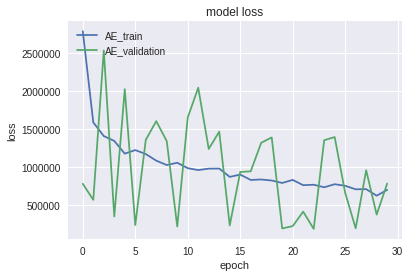

In [102]:
import matplotlib.pyplot as plt

plt.title('model loss')
legend_names = []
# summarize history for accuracy
for name, model_hist in hist.items():
  plt.plot(model_hist.history['loss'])
  plt.plot(model_hist.history['val_loss'])
  legend_names.extend([name+'_train', name+'_validation'])
  
plt.legend(legend_names, loc='upper left')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

2. True Price vs. Generate Price


===== Model Name: AE =====


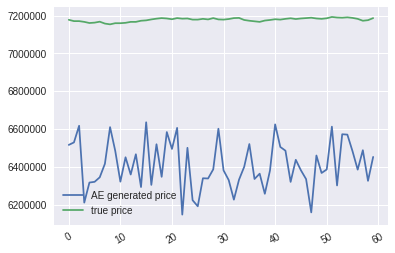

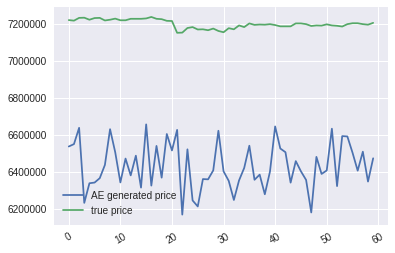

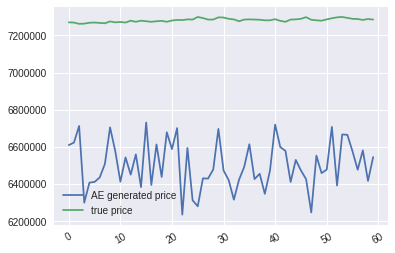

In [105]:
for name, prediction_model in predictions.items():
  print("===== Model Name: {} =====".format(name))
  
  for _ in range(3):
    i = np.random.choice(len(prediction_model))
    plt.plot(prediction_model[i], label = name+' generated price')    
    plt.plot(test_Y[i], label = 'true price')
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()
